In [1]:
!pwd

/home/ec2-user/SageMaker/sprint_2019-04-23


In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import boto3
import os
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker
from sagemaker import get_execution_role
from sklearn.model_selection import train_test_split
import numpy as np

import sagemaker
from random import shuffle
import multiprocessing
from multiprocessing import Pool
import csv
import nltk
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

In [3]:
#s3://sprint-dql-banking/paysim1.zip
bucket = "sprint-dql-banking"
key = "paysim1.zip"

s3 = boto3.resource('s3')
#s3.Bucket(bucket).download_file(key, "paysim1.zip")

# Load and Exploring the data

In [4]:
init_df = pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [5]:
init_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
init_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
init_df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
init_df=init_df[[ 'isFraud','step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest','isFlaggedFraud']]

In [7]:
init_df.drop(columns = ["nameOrig", "nameDest"], axis =1, inplace = True)

In [8]:
init_df = pd.get_dummies(init_df, columns = ["type"])

In [9]:
churn = init_df.copy(deep = True) #churn dataframe is used for second classifier, which has extra feature engineering on inputs first.

In [12]:
# Frequency tables for each categorical feature
for column in churn.select_dtypes(include=['object']).columns:
    print(column)
    display(pd.crosstab(index=churn[column], columns='% observations', normalize='columns'))


,isFraud,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,1.290820e-03,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,2.514687e-06,2.199226e-01,3.516633e-01,6.511783e-03,3.381461e-01,8.375622e-02
std,3.590480e-02,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,1.585775e-03,4.141940e-01,4.774895e-01,8.043246e-02,4.730786e-01,2.770219e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
max,1.000000e+00,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


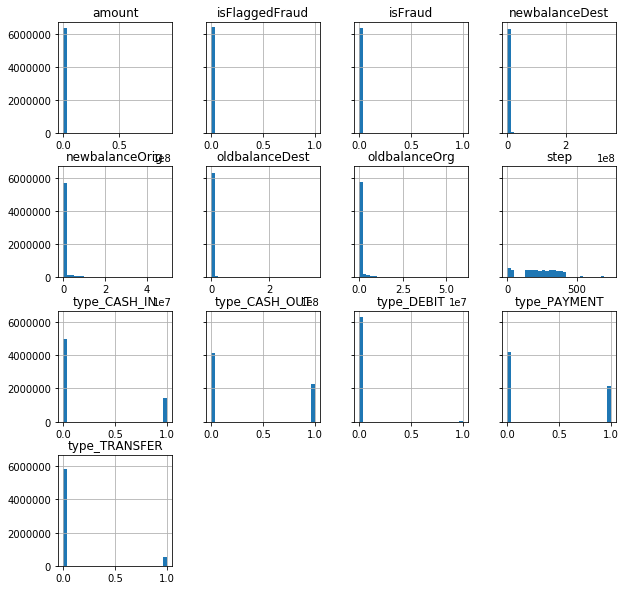

In [13]:
# Histograms for each numeric features
display(churn.describe())
%matplotlib inline
hist = churn.hist(bins=30, sharey=True, figsize=(10, 10))

In [14]:
churn["isFraud"].sum() / float(len(churn))

0.001290820448180152

In [15]:
display(churn.corr())
#pd.plotting.scatter_matrix(churn, figsize=(12, 12))
#plt.show()

,isFraud,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
isFraud,1.000000,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,0.044109,-0.019089,0.011256,-0.002911,-0.025697,0.053869
step,0.031578,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.003277,0.004077,-0.012918,0.002869,0.004926,0.006925
amount,0.076688,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.012295,-0.009621,-0.004376,-0.023379,-0.197444,0.365896
oldbalanceOrg,0.010154,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.003835,0.506761,-0.200899,-0.021450,-0.189486,-0.081593
newbalanceOrig,-0.008148,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,0.003776,0.527373,-0.210977,-0.021872,-0.193915,-0.087355
oldbalanceDest,-0.005885,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.000513,0.076105,0.086028,0.009347,-0.231455,0.130476
newbalanceDest,0.000535,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,-0.000529,0.034988,0.093476,0.006346,-0.238315,0.191701
isFlaggedFraud,0.044109,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,1.000000,-0.000842,-0.001168,-0.000128,-0.001133,0.005245
type_CASH_IN,-0.019089,0.004077,-0.009621,0.506761,0.527373,0.076105,0.034988,-0.000842,1.000000,-0.391047,-0.042987,-0.379522,-0.160535
type_CASH_OUT,0.011256,-0.012918,-0.004376,-0.200899,-0.210977,0.086028,0.093476,-0.001168,-0.391047,1.000000,-0.059625,-0.526422,-0.222672


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


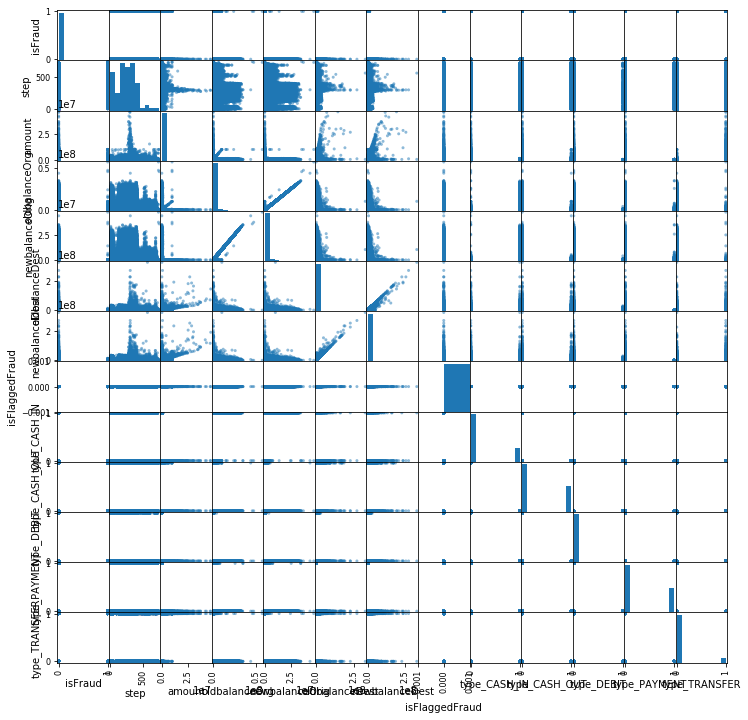

In [16]:
partial_churn = churn.sample(frac=0.05, replace=False, random_state=1)

import matplotlib.pyplot as plt
%matplotlib inline
pd.plotting.scatter_matrix(partial_churn, figsize=(12, 12))
plt.show()

In [10]:
churn.select_dtypes(include=['object']).nunique()

Series([], dtype: float64)

In [19]:
#churn["type"].value_counts()

In [11]:
# partial_churn = churn.sample(frac=0.05, replace=False, random_state=1)
# partial_churn = pd.get_dummies(partial_churn, columns = ["type"])
# partial_churn.columns

# Separate the data, Train and Deploy the model 

In [20]:
train_data, validation_data, test_data = np.split(init_df.sample(frac=1, random_state=1729), [int(0.7 * len(init_df)), int(0.9 * len(init_df))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)

In [21]:
train_data.shape, validation_data.shape, test_data.shape, test_data.columns

((4453834, 13),
 (1272524, 13),
 (636262, 13),
 Index(['isFraud', 'step', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
        'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud', 'type_CASH_IN',
        'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER'],
       dtype='object'))

In [22]:
# train = pd.read_csv('../Data/train.csv', names = list(range(89)))
# test = pd.read_csv('../Data/test.csv', names = list(range(89)))

# train_labels = np.array(train[0]).astype("float32")
# train_features = np.array(train.drop(0, axis=1)).astype("float32")
# test_labels = np.array(test[0]).astype("float32")
# test_features  = np.array(test.drop(0, axis=1)).astype("float32")

In [12]:
def get_base_estimator(clf, sess, role):

    container = get_image_uri(boto3.Session().region_name, clf)

    est = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, clf),
                                    sagemaker_session=sess)
    return est

In [13]:
def get_estimator(clf, sess, role):
    
    container = get_image_uri(boto3.Session().region_name, clf)

    
    if clf == 'xgboost':
        est = get_base_estimator(clf, sess, role)
        est.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)
        
    elif clf == 'linear-learner':
        
        est = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                               train_instance_count=1,
                                               train_instance_type='ml.m4.xlarge',
                                               predictor_type='binary_classifier',
                                               num_classes=2)

    elif clf == 'knn':
        est = sagemaker.KNN(role=sagemaker.get_execution_role(),
                                              k = 10,
                                               train_instance_count=1,
                                               train_instance_type='ml.m4.xlarge',
                                               predictor_type='classifier',
                                                sample_size = 200)
        

        
        
    elif clf == 'factorization-machines':
        est = sagemaker.FactorizationMachines(role=sagemaker.get_execution_role(),
                                               train_instance_count=1,
                                               train_instance_type='ml.m4.xlarge',
                                               predictor_type='binary_classifier',
                                                num_factors = 2)
        
        
    return est

In [14]:
sess = sagemaker.Session()
role = get_execution_role()
client = boto3.client('sagemaker')
bucket = sess.default_bucket()
bucket = "sprint-dql-banking"

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-023375022819


In [36]:
prefix = 'xgboost' #project name
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')
#boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/validation.csv')).upload_file('test.csv')

s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_validation_train = sagemaker.s3_input(s3_data='s3://{}/{}/validation'.format(bucket, prefix), content_type='csv')

In [27]:
# train_channel = "xgoost/train"
# validation_channel = "xgoost/validation"
# sess.upload_data(path='train.csv', bucket=bucket, key_prefix=train_channel)
# sess.upload_data(path='validation.csv', bucket=bucket, key_prefix=validation_channel)

In [28]:
xgboost_clf = get_estimator("xgboost", sess, role)

In [29]:
data_channels = {'train': s3_input_train, 'validation': s3_validation_train}

In [30]:
xgboost_clf.fit(data_channels)

INFO:sagemaker:Creating training-job with name: xgboost-2019-04-25-00-38-02-665


2019-04-25 00:38:02 Starting - Starting the training job...
2019-04-25 00:38:03 Starting - Launching requested ML instances......
2019-04-25 00:39:16 Starting - Preparing the instances for training......
2019-04-25 00:40:22 Downloading - Downloading input data...
2019-04-25 00:41:00 Training - Training image download completed. Training in progress..
Arguments: train
[2019-04-25:00:41:00:INFO] Running standalone xgboost training.
[2019-04-25:00:41:00:INFO] File size need to be processed in the node: 305.95mb. Available memory size in the node: 8401.61mb
[2019-04-25:00:41:00:INFO] Determined delimiter of CSV input is ','
[00:41:00] S3DistributionType set as FullyReplicated
[00:41:02] 4453834x12 matrix with 53446008 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-04-25:00:41:02:INFO] Determined delimiter of CSV input is ','
[00:41:02] S3DistributionType set as FullyReplicated
[00:41:03] 1272524x12 matrix with 15270288 entries loaded from /opt/ml/i

[00:42:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=5
[40]#011train-error:0.000347#011validation-error:0.000352
[00:42:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 6 pruned nodes, max_depth=5
[41]#011train-error:0.000343#011validation-error:0.000349
[00:42:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 2 pruned nodes, max_depth=5
[42]#011train-error:0.000339#011validation-error:0.000349
[00:43:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=5
[43]#011train-error:0.000339#011validation-error:0.000348
[00:43:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=5
[44]#011train-error:0.000338#011validation-error:0.000349
[00:43:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 4 pruned nodes, max_depth=5
[45]#011train-error:0.000333#011valida

[00:44:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 12 pruned nodes, max_depth=5
[86]#011train-error:0.000253#011validation-error:0.000276
[00:44:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 8 pruned nodes, max_depth=5
[87]#011train-error:0.000252#011validation-error:0.000277
[00:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 16 pruned nodes, max_depth=5
[88]#011train-error:0.000252#011validation-error:0.000277
[00:45:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 18 pruned nodes, max_depth=5
[89]#011train-error:0.000251#011validation-error:0.000277
[00:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=5
[90]#011train-error:0.00025#011validation-error:0.000277
[00:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=5
[91]#011train-error:0.000249#011vali

In [31]:
#sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)
xgb_predictor = xgboost_clf.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2019-04-25-00-46-51-338
INFO:sagemaker:Creating endpoint with name xgboost-2019-04-25-00-38-02-665


----------------------------------------------------------------------------!

In [32]:
#xgb_predictor =sagemaker.RealTimePredictor('xgboost-2019-04-24-18-30-00-860', sagemaker_session= sess)

# Evaluate the Model

In [48]:
import sagemaker
from sagemaker.predictor import csv_serializer
import matplotlib.pyplot as plt
%matplotlib inline

def predict(classifier, data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, classifier.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

In [ ]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

predictions = predict(xgb_predictor,test_data.as_matrix()[:, 1:])

In [35]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,635419,16
1,159,668


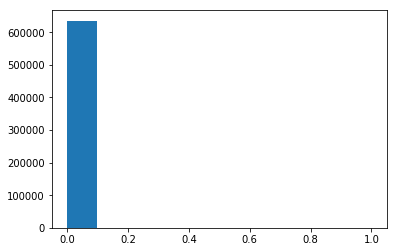

In [37]:
plt.hist(predictions)
plt.show()

# Compare the result by extra feature engieering with MinMaxScaler

In [20]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_columns = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest","newbalanceDest"]
# churn.select_dtypes(include=['object']).columns

churn[scaled_columns] = scaler.fit_transform(churn[scaled_columns])

In [21]:
churn.describe()

,isFraud,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,1.290820e-03,2.433972e+02,1.945599e-03,1.399484e-02,1.724540e-02,3.091721e-03,3.439269e-03,2.514687e-06,2.199226e-01,3.516633e-01,6.511783e-03,3.381461e-01,8.375622e-02
std,3.590480e-02,1.423320e+02,6.532045e-03,4.847261e-02,5.897038e-02,9.547833e-03,1.031539e-02,1.585775e-03,4.141940e-01,4.774895e-01,8.043246e-02,4.730786e-01,2.770219e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,1.560000e+02,1.448374e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,2.390000e+02,8.099034e-04,2.384491e-04,0.000000e+00,3.727521e-04,6.026781e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,3.350000e+02,2.257778e-03,1.801042e-03,2.909313e-03,2.648861e-03,3.121768e-03,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
max,1.000000e+00,7.430000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


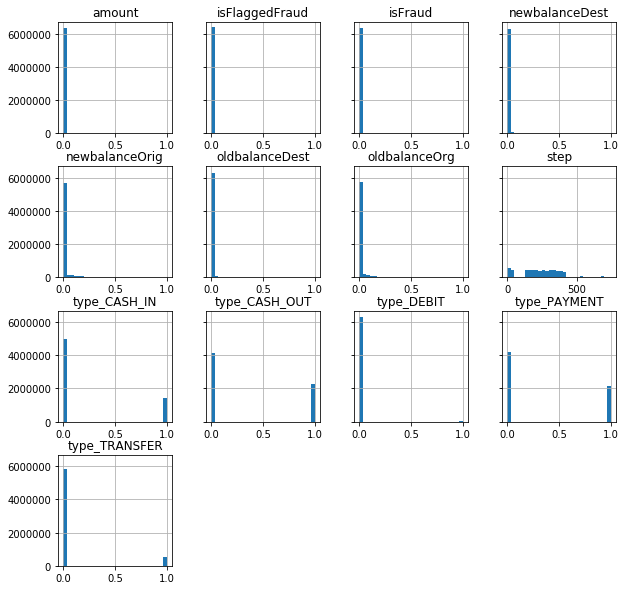

In [22]:
%matplotlib inline
hist = churn.hist(bins=30, sharey=True, figsize=(10, 10))

## Original data before MinMaxScaler for reference

,isFraud,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,1.290820e-03,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,2.514687e-06,2.199226e-01,3.516633e-01,6.511783e-03,3.381461e-01,8.375622e-02
std,3.590480e-02,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,1.585775e-03,4.141940e-01,4.774895e-01,8.043246e-02,4.730786e-01,2.770219e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
max,1.000000e+00,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


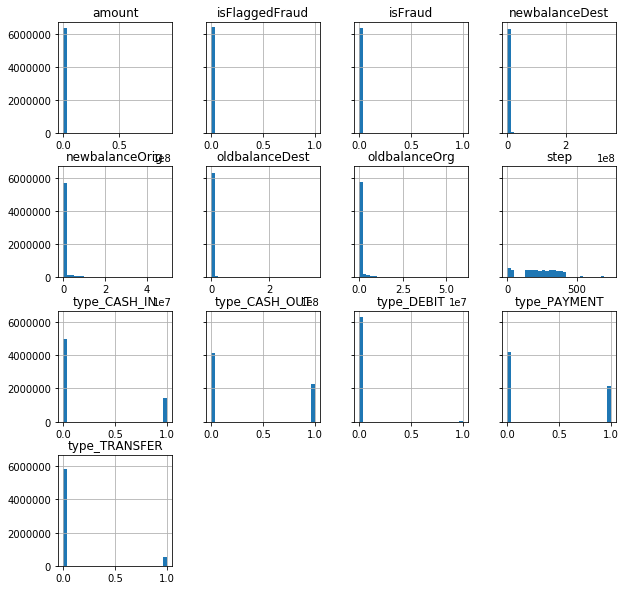

In [13]:
# Histograms for each numeric features
display(churn.describe())
%matplotlib inline
hist = churn.hist(bins=30, sharey=True, figsize=(10, 10))

In [23]:
train_data, validation_data, test_data = np.split(churn.sample(frac=1, random_state=1729), [int(0.7 * len(churn)), int(0.9 * len(init_df))])
train_data.to_csv('train-better.csv', header=False, index=False)
validation_data.to_csv('validation-better.csv', header=False, index=False)

prefix = 'xgboost-better' #project name
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train-better.csv')).upload_file('train-better.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation-better.csv')).upload_file('validation-better.csv')

s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_validation_train = sagemaker.s3_input(s3_data='s3://{}/{}/validation'.format(bucket, prefix), content_type='csv')

data_channels = {'train': s3_input_train, 'validation': s3_validation_train}

xgboost_clf_better = get_estimator("xgboost", sess, role)
xgboost_clf_better.fit(data_channels)

INFO:sagemaker:Creating training-job with name: xgboost-2019-04-25-15-22-37-235


2019-04-25 15:22:37 Starting - Starting the training job...
2019-04-25 15:22:38 Starting - Launching requested ML instances......
2019-04-25 15:23:49 Starting - Preparing the instances for training......
2019-04-25 15:24:55 Downloading - Downloading input data...
2019-04-25 15:25:29 Training - Training image download completed. Training in progress.
Arguments: train
[2019-04-25:15:25:29:INFO] Running standalone xgboost training.
[2019-04-25:15:25:29:INFO] File size need to be processed in the node: 523.4mb. Available memory size in the node: 8397.71mb
[2019-04-25:15:25:29:INFO] Determined delimiter of CSV input is ','
[15:25:29] S3DistributionType set as FullyReplicated
[15:25:31] 4453834x12 matrix with 53446008 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-04-25:15:25:31:INFO] Determined delimiter of CSV input is ','
[15:25:31] S3DistributionType set as FullyReplicated
[15:25:32] 1272524x12 matrix with 15270288 entries loaded from /opt/ml/inp

[15:27:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 4 pruned nodes, max_depth=5
[40]#011train-error:0.000383#011validation-error:0.000376
[15:27:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 10 pruned nodes, max_depth=5
[41]#011train-error:0.000377#011validation-error:0.000376
[15:27:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=5
[42]#011train-error:0.000376#011validation-error:0.000371
[15:27:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[43]#011train-error:0.000373#011validation-error:0.000372
[15:27:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=5
[44]#011train-error:0.000373#011validation-error:0.000372
[15:27:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 2 pruned nodes, max_depth=5
[45]#011train-error:0.000371#011valid

[15:29:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=5
[86]#011train-error:0.000323#011validation-error:0.000339
[15:29:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 10 pruned nodes, max_depth=4
[87]#011train-error:0.000322#011validation-error:0.000339
[15:29:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 18 pruned nodes, max_depth=5
[88]#011train-error:0.000321#011validation-error:0.00034
[15:29:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 10 pruned nodes, max_depth=4
[89]#011train-error:0.00032#011validation-error:0.000336
[15:29:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=5
[90]#011train-error:0.00032#011validation-error:0.000335
[15:29:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 4 pruned nodes, max_depth=5
[91]#011train-error:0.000318#011validat

In [25]:
xgb_predictor_better = xgboost_clf_better.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2019-04-25-15-31-50-026
INFO:sagemaker:Creating endpoint with name xgboost-2019-04-25-15-22-37-235


-----------------------------------------------------------------------------------------------------!

In [46]:
test_data.head()

,isFraud,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
649918,0,35,0.001434,0.000193,0.002905,0.000000,0.000000,0,1,0,0,0,0
6078014,0,518,0.000064,0.000988,0.001067,0.000000,0.000000,0,0,0,0,1,0
3352247,0,253,0.000031,0.000102,0.000064,0.002709,0.002716,0,0,1,0,0,0
2875453,0,227,0.002093,0.000000,0.000000,0.000698,0.001240,0,0,1,0,0,0
5729113,0,399,0.001007,0.001800,0.000286,0.000000,0.000261,0,0,1,0,0,0


In [50]:
xgb_predictor_better.content_type = 'text/csv'
xgb_predictor_better.serializer = csv_serializer
xgb_predictor_better.deserializer = None
predictions = predict(xgb_predictor_better,test_data.as_matrix()[:, 1:])

In [51]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,635427,8
1,198,629


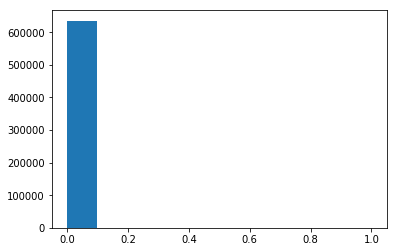

In [52]:
plt.hist(predictions)
plt.show()

# Threshold Adjustments per cost analysis

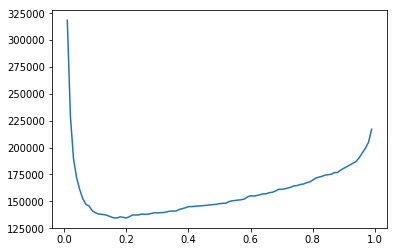

Cost is minimized near a cutoff of: 0.16 for a cost of: 134600


In [48]:
cutoffs = np.arange(0.01, 1, 0.01)
costs = []
for c in cutoffs:
    costs.append(np.sum(np.sum(np.array([[0, 100], [500, 100]]) * 
                               pd.crosstab(index=test_data.iloc[:, 0], 
                                           columns=np.where(predictions > c, 1, 0)))))

costs = np.array(costs)
plt.plot(cutoffs, costs)
plt.show()
print('Cost is minimized near a cutoff of:', cutoffs[np.argmin(costs)], 'for a cost of:', np.min(costs))

In [49]:
threshold_predictions = np.where(predictions > 0.16, 1, 0)
pd.crosstab(index=test_data.iloc[:, 0], columns=threshold_predictions , rownames=['actual'], colnames=['predictions'])

predictions,0,1
actual,,
0,635292,143
1,94,733


In [50]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [51]:
print ("\nwith default threshold of 0.5\n")
a_score = accuracy_score(test_data.iloc[:, 0], np.round(predictions))
p_score = precision_score(test_data.iloc[:, 0], np.round(predictions))
r_score = recall_score(test_data.iloc[:, 0], np.round(predictions))
f_score = f1_score(test_data.iloc[:, 0], np.round(predictions))
print (a_score, p_score, r_score, f_score)

print ("\nwith cost-optimized threshold of 0.16\n")
a_score = accuracy_score(test_data.iloc[:, 0], threshold_predictions)
p_score = precision_score(test_data.iloc[:, 0], threshold_predictions)
r_score = recall_score(test_data.iloc[:, 0], threshold_predictions)
f_score = f1_score(test_data.iloc[:, 0], threshold_predictions)
print (a_score, p_score, r_score, f_score)


with default threshold of 0.5

0.9997249560715554 0.9766081871345029 0.8077388149939541 0.884182660489742

with cost-optimized threshold of 0.16

0.9996275119369065 0.83675799086758 0.8863361547762999 0.8608338226658838


## Results from Second trainned model

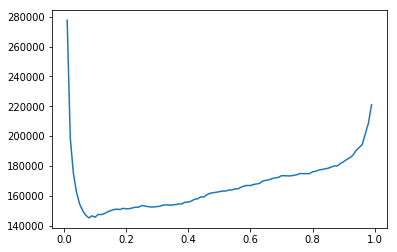

Cost is minimized near a cutoff of: 0.08 for a cost of: 145100

with default threshold of 0.5

0.999676234004231 0.9874411302982732 0.7605804111245466 0.8592896174863387

with cost-optimized threshold of 0.16

0.9996337986552709 0.889763779527559 0.8198307134220073 0.8533668974197608


In [53]:
cutoffs = np.arange(0.01, 1, 0.01)
costs = []
for c in cutoffs:
    costs.append(np.sum(np.sum(np.array([[0, 100], [500, 100]]) * 
                               pd.crosstab(index=test_data.iloc[:, 0], 
                                           columns=np.where(predictions > c, 1, 0)))))

costs = np.array(costs)
plt.plot(cutoffs, costs)
plt.show()
print('Cost is minimized near a cutoff of:', cutoffs[np.argmin(costs)], 'for a cost of:', np.min(costs))

threshold_predictions = np.where(predictions > 0.16, 1, 0)
pd.crosstab(index=test_data.iloc[:, 0], columns=threshold_predictions , rownames=['actual'], colnames=['predictions'])

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

print ("\nwith default threshold of 0.5\n")
a_score = accuracy_score(test_data.iloc[:, 0], np.round(predictions))
p_score = precision_score(test_data.iloc[:, 0], np.round(predictions))
r_score = recall_score(test_data.iloc[:, 0], np.round(predictions))
f_score = f1_score(test_data.iloc[:, 0], np.round(predictions))
print (a_score, p_score, r_score, f_score)

print ("\nwith cost-optimized threshold of 0.16\n")
a_score = accuracy_score(test_data.iloc[:, 0], threshold_predictions)
p_score = precision_score(test_data.iloc[:, 0], threshold_predictions)
r_score = recall_score(test_data.iloc[:, 0], threshold_predictions)
f_score = f1_score(test_data.iloc[:, 0], threshold_predictions)
print (a_score, p_score, r_score, f_score)

### with default threshold of 0.5
* 0.9997249560715554 0.9766081871345029 0.8077388149939541 0.884182660489742
* 0.999676234004231 0.9874411302982732 0.7605804111245466 0.8592896174863387

### with cost-optimized threshold of 0.16
* 0.9996337986552709 0.889763779527559 0.8198307134220073 0.8533668974197608
* 0.9996275119369065 0.83675799086758  0.8863361547762999 0.8608338226658838

In [54]:
#sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)
#sagemaker.Session().delete_endpoint(xgb_predictor_better.endpoint)

# Start tunning 

In [34]:
def get_tuner(clf, est):
        
    if clf == 'xgboost':
        objective_metric_name = 'validation:auc'

        hyperparameter_ranges = {'eta': ContinuousParameter(0, 1),
                        'min_child_weight': ContinuousParameter(1, 10),
                        'alpha': ContinuousParameter(0, 2),
                        'max_depth': IntegerParameter(1, 10)}
        
    elif clf == 'knn':
        
        objective_metric_name = 'test:accuracy'

        hyperparameter_ranges = {'k': IntegerParameter(1, 1024),
                        'sample_size': IntegerParameter(256, 20000000)}
        
    elif clf == 'linear-learner':
        objective_metric_name = 'test:recall'
        
        hyperparameter_ranges = {'l1': ContinuousParameter(0.0000001,1),
                            'use_bias': CategoricalParameter([True, False])}
        
    elif clf == 'factorization-machines':
        objective_metric_name = 'test:binary_classification_accuracy'
        
        hyperparameter_ranges = {'bias_wd': IntegerParameter(1, 1000)}
        
    tuner = HyperparameterTuner(est,
                    objective_metric_name,
                    hyperparameter_ranges,
                    max_jobs=30,
                    max_parallel_jobs=3)
    
    return tuner

In [41]:
def run_training_job(clf):

    # build the estimator
    est = get_estimator(clf, sess, role)

    # get the hyperparameter tuner config 
    # set this to look for recall somehow 
    if clf == 'xgboost':
        
        tuner = get_tuner(clf, est)
        
        #tuner.fit({'train': s3_input_train, 'test': s3_input_test}) 
        tuner.fit({'train': s3_input_train, 'validation': s3_input_test}) 

    else:
        # set the records
        train_records = est.record_set(train_features, train_labels, channel='train')
        test_records = est.record_set(test_features, test_labels, channel='validation')

        tuner = get_tuner(clf, est)
        
        tuner.fit([train_records, test_records])
    

In [42]:
def magic_loop(models_to_run):
    pool = Pool(processes=multiprocessing.cpu_count())
    transformed_rows = pool.map(run_training_job, models_to_run)
    pool.close() 
    pool.join()

In [43]:
#clfs = ['xgboost', 'linear-learner', 'factorization-machines', 'knn']

s3_input_train = s3_input_train
s3_input_test = s3_validation_train


clfs = ['xgboost']
magic_loop(clfs)

INFO:sagemaker:Creating hyperparameter tuning job with name: xgboost-190425-1638


# Go to HPO_Analyze_TuningJob_Results